In [12]:

import yfinance as yf
import requests
from textblob import TextBlob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [13]:

API_KEY = '5f43cdbdfb4f49768b981f10e41a99c1'  # Replace with your actual API key

def fetch_stock_data(symbol, period='1mo'):
    stock_data = yf.download(symbol, period=period)
    return stock_data['Close']

def fetch_news_articles(symbol, start_date, end_date):
    url = (f'https://newsapi.org/v2/everything?q={symbol}&from={start_date}&to={end_date}'
           f'&sortBy=publishedAt&apiKey={API_KEY}')
    response = requests.get(url)
    return response.json()['articles']

def analyze_sentiment(articles):
    sentiments = []    
    for article in articles:
        analysis = TextBlob(str(article['description']))
        polarity = analysis.sentiment.polarity
        sentiments.append({
            'date': article['publishedAt'],
            'title': article['title'],
            'description': article['description'],
            'sentiment': 'positive' if polarity > 0 else 'negative' if polarity < 0 else 'neutral'
        })
    return sentiments


In [14]:

stock_symbols = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']
results = {symbol: {
    'stock_data': fetch_stock_data(symbol),
    'sentiments': analyze_sentiment(fetch_news_articles(symbol, 
        fetch_stock_data(symbol).index[0].strftime('%Y-%m-%d'), 
        fetch_stock_data(symbol).index[-1].strftime('%Y-%m-%d')))
} for symbol in stock_symbols}

stock_list = [data['stock_data'].mean() for _, data in results.items()]
sentiment_list = [sum([1 if s['sentiment'] == 'positive' else -1 if s['sentiment'] == 'negative' else 0 for s in data['sentiments']]) / len(data['sentiments']) for _, data in results.items()]

df = pd.DataFrame({
    'Stock Symbol': list(results.keys()),
    'Average Stock Price': stock_list,
    'Average Sentiment Value': sentiment_list
})


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [18]:
data = {}

for symbol in stock_symbols:
    # Fetch stock data
    stock_data = fetch_stock_data(symbol)
    dates = stock_data.index.strftime('%Y-%m-%d').tolist()
    stock_prices = stock_data.tolist()
    
    # Fetch and analyze sentiments
    articles = fetch_news_articles(symbol, dates[0], dates[-1])
    sentiments_data = analyze_sentiment(articles)
    
    # Aggregate sentiments for each date
    sentiments = []
    for date in dates:
        # Filter sentiments for the specific date
        sentiments_on_date = [s['sentiment'] for s in sentiments_data if s['date'].startswith(date)]
        # Convert sentiments to numerical values and compute average sentiment for the day
        numerical_sentiments = [1 if s == 'positive' else -1 if s == 'negative' else 0 for s in sentiments_on_date]
        avg_sentiment = sum(numerical_sentiments) / len(numerical_sentiments) if numerical_sentiments else 0
        sentiments.append(avg_sentiment)
    
    # Store the data
    data[symbol] = {
        'dates': dates,
        'stock_prices': stock_prices,
        'sentiments': sentiments
    }

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


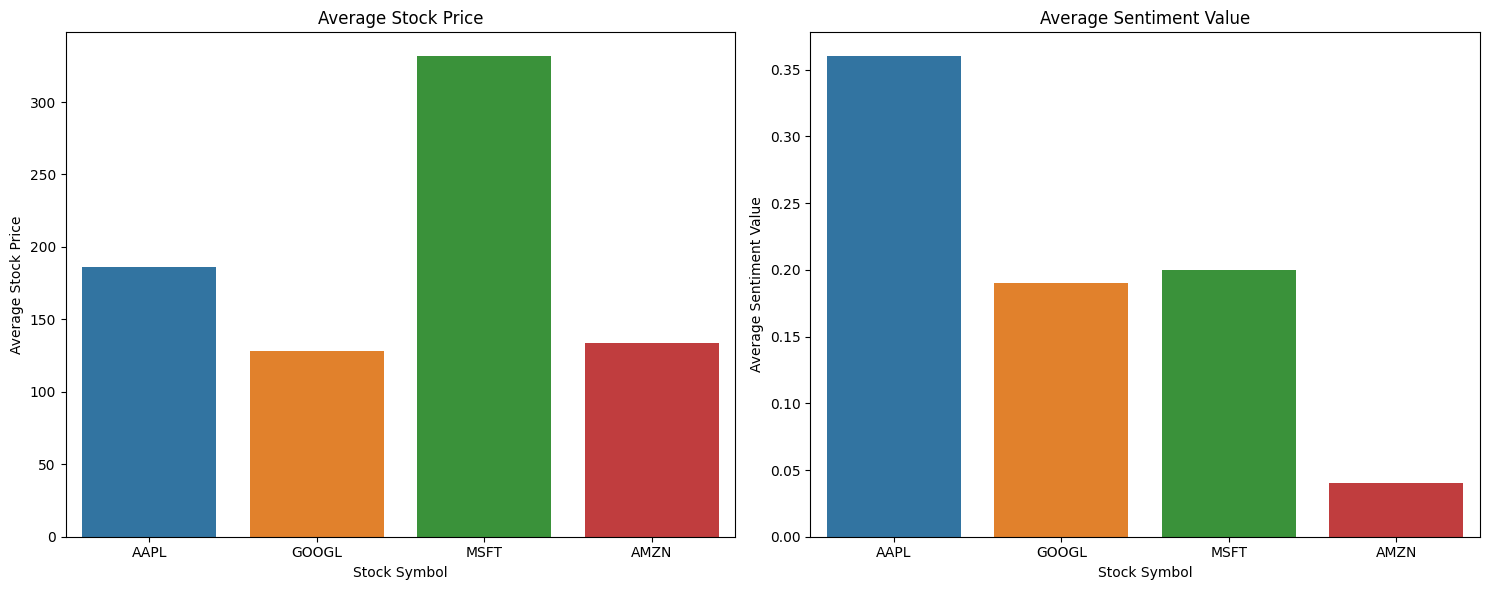

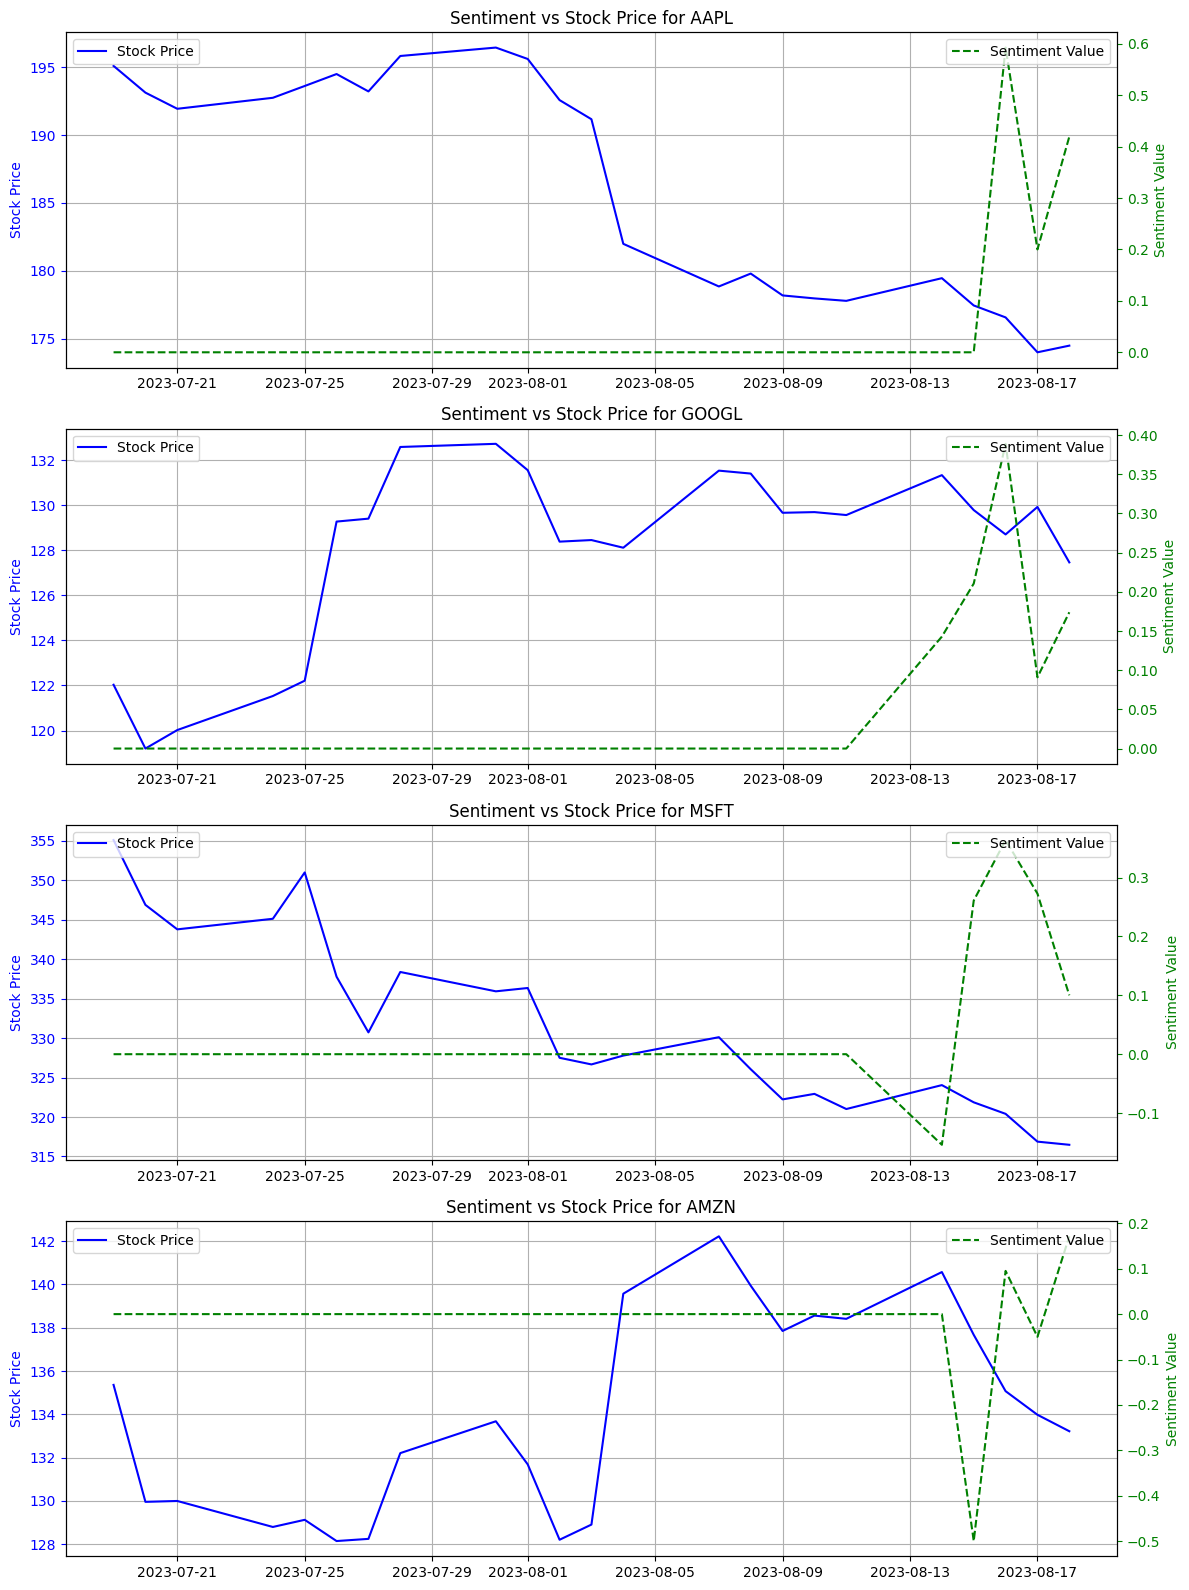

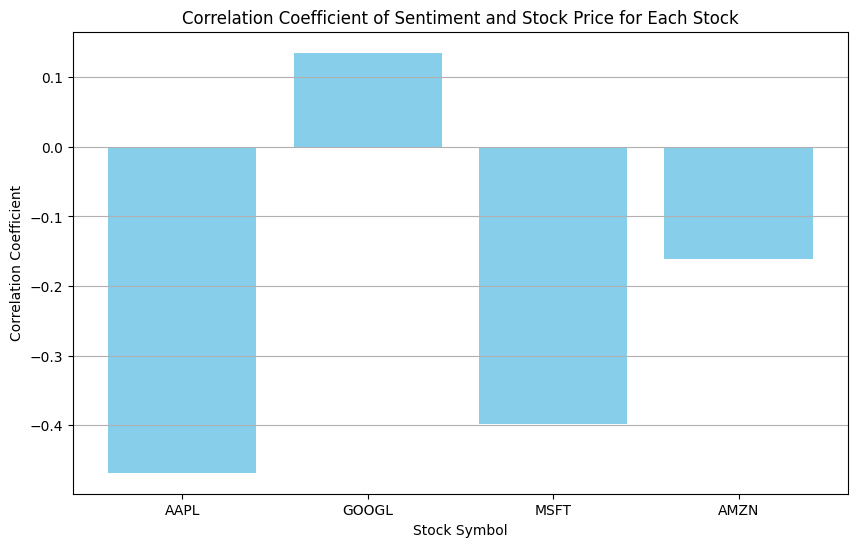

In [19]:

# Bar plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.barplot(x='Stock Symbol', y='Average Stock Price', data=df, ax=axes[0])
axes[0].set_title('Average Stock Price')
axes[0].set_ylabel('Average Stock Price')
axes[0].set_xlabel('Stock Symbol')
sns.barplot(x='Stock Symbol', y='Average Sentiment Value', data=df, ax=axes[1])
axes[1].set_title('Average Sentiment Value')
axes[1].set_ylabel('Average Sentiment Value')
axes[1].set_xlabel('Stock Symbol')
plt.tight_layout()
plt.show()

# Visualization for Question 1: Time series plot for sentiment vs. stock price.
fig, axes = plt.subplots(len(data), 1, figsize=(12, 4 * len(data)))

for i, (symbol, values) in enumerate(data.items()):
    df_temp = pd.DataFrame({
        'Date': pd.to_datetime(values['dates']),
        'Stock Price': values['stock_prices'],
        'Sentiment Value': values['sentiments']
    })
    
    ax = axes[i]
    ax.plot(df_temp['Date'], df_temp['Stock Price'], color='b', label='Stock Price')
    ax.set_ylabel('Stock Price', color='b')
    ax.tick_params('y', colors='b')
    ax.legend(loc='upper left')
    
    ax2 = ax.twinx()
    ax2.plot(df_temp['Date'], df_temp['Sentiment Value'], color='g', label='Sentiment Value', linestyle='--')
    ax2.set_ylabel('Sentiment Value', color='g')
    ax2.tick_params('y', colors='g')
    ax2.legend(loc='upper right')
    
    ax.set_title(f'Sentiment vs Stock Price for {symbol}')
    ax.grid(True)

fig.tight_layout()
plt.show()

# Visualization for Question 3: Bar chart comparing correlation coefficients for each stock.
correlation_coeffs = []

for symbol, values in data.items():
    df_temp = pd.DataFrame({
        'Stock Price': values['stock_prices'],
        'Sentiment Value': values['sentiments']
    })
    correlation_coeffs.append(df_temp.corr().iloc[0, 1])

plt.figure(figsize=(10, 6))
plt.bar(data.keys(), correlation_coeffs, color='skyblue')
plt.xlabel('Stock Symbol')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation Coefficient of Sentiment and Stock Price for Each Stock')
plt.grid(axis='y')

plt.show()